In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [4]:
class QLearningInventory:
    def __init__(self, user_capacity, poisson_lambda, holding_cost, stockout_cost, gamma, alpha, epsilon, episodes, max_actions_per_episode):
        self.user_capacity = user_capacity
        self.poisson_lambda = poisson_lambda
        self.holding_cost = holding_cost
        self.stockout_cost = stockout_cost
        self.gamma = gamma  # discount factor
        self.alpha = alpha  # learning rate
        self.epsilon = epsilon  # exploration rate
        self.episodes = episodes
        self.max_actions_per_episode = max_actions_per_episode
        self.Q = {}
        self.rewards_per_episode = []

    def initialize_Q(self):
        # Initialize the Q-table as a dictionary
        Q = {}
        for alpha in range(self.user_capacity + 1):
            for beta in range(self.user_capacity + 1):
                state = (alpha, beta)
                Q[state] = {}
                max_action = max(0, self.user_capacity - (alpha + beta))
                for action in range(max_action + 1):
                    Q[state][action] = np.random.uniform(0, 1)  # Small random values
        return Q

    def choose_action(self, state):
        # Epsilon-greedy action selection
        max_possible_order = max(0, self.user_capacity - (state[0] + state[1]))
        if state not in self.Q:
            self.Q[state] = {}
            for action in range(max_possible_order + 1):
                self.Q[state][action] = np.random.uniform(0, 1)
        if np.random.rand() < self.epsilon:
            return np.random.choice(max_possible_order + 1)
        else:
            q_values = self.Q[state]
            max_q = max(q_values.values())
            actions_with_max_q = [action for action, q in q_values.items() if q == max_q]
            return random.choice(actions_with_max_q)

    def simulate_transition_and_reward(self, state, action):
        alpha, beta = state
        init_inv = alpha + beta + action
        demand = np.random.poisson(self.poisson_lambda)
        new_alpha = max(0, init_inv - demand)
        new_beta = action
        # Ensure new_alpha + new_beta does not exceed capacity
        if new_alpha + new_beta > self.user_capacity:
            excess = new_alpha + new_beta - self.user_capacity
            new_alpha = max(0, new_alpha - excess)
        # Compute reward
        holding_cost = -new_alpha * self.holding_cost
        stockout_cost = 0
        if demand > init_inv:
            stockout_cost = -(demand - init_inv) * self.stockout_cost
        reward = holding_cost + stockout_cost
        next_state = (new_alpha, new_beta)
        return next_state, reward

    def update_Q(self, state, action, reward, next_state):
        if state not in self.Q:
            self.Q[state] = {}
            max_possible_order = max(0, self.user_capacity - (state[0] + state[1]))
            for a in range(max_possible_order + 1):
                self.Q[state][a] = np.random.uniform(0, 1)
        if next_state not in self.Q:
            self.Q[next_state] = {}
            max_possible_order = max(0, self.user_capacity - (next_state[0] + next_state[1]))
            for a in range(max_possible_order + 1):
                self.Q[next_state][a] = np.random.uniform(0, 1)
        best_next_action = max(self.Q[next_state], key=self.Q[next_state].get)
        td_target = reward + self.gamma * self.Q[next_state][best_next_action]
        td_error = td_target - self.Q[state][action]
        self.Q[state][action] += self.alpha * td_error

    def train(self):
        self.Q = self.initialize_Q()  # Reinitialize Q-table for each training run
        rewards_per_episode = []
        for episode in range(self.episodes):
            alpha_0 = random.randint(0, self.user_capacity)
            beta_0 = random.randint(0, self.user_capacity - alpha_0)
            state = (alpha_0, beta_0)
            total_reward = 0
            action_taken = 0
            while action_taken < self.max_actions_per_episode:
                action = self.choose_action(state)
                next_state, reward = self.simulate_transition_and_reward(state, action)
                self.update_Q(state, action, reward, next_state)
                state = next_state
                total_reward += reward
                action_taken += 1
            rewards_per_episode.append(total_reward)
            # Optionally, decrease epsilon over time
            # self.epsilon = max(self.epsilon * 0.99, 0.01)
        self.rewards_per_episode = rewards_per_episode

    def get_optimal_policy(self):
        policy = {}
        for state in self.Q:
            q_values = self.Q[state]
            max_q = max(q_values.values())
            actions_with_max_q = [action for action, q in q_values.items() if q == max_q]
            policy[state] = random.choice(actions_with_max_q)
        return policy

    def test_policy(self, policy, episodes):
        total_reward = 0
        for _ in range(episodes):
            alpha_0 = random.randint(0, self.user_capacity)
            beta_0 = random.randint(0, self.user_capacity - alpha_0)
            state = (alpha_0, beta_0)  # Initialize the state
            action_taken = 0
            while action_taken < self.max_actions_per_episode:
                action = policy.get(state, 0)
                next_state, reward = self.simulate_transition_and_reward(state, action)
                total_reward += reward
                state = next_state
                action_taken += 1
        avg_reward = total_reward / episodes
        return avg_reward

In [5]:
# Parameters
user_capacity = 10
poisson_lambda = 4
holding_cost = 1  # Adjusted to 1 for better scaling in rewards
stockout_cost = 10
gamma = 0.9
alpha = 0.1
epsilon = 0.1
episodes = 1000
max_actions_per_episode = 100

# Create the QLearningInventory instance
ql = QLearningInventory(user_capacity, poisson_lambda, holding_cost, stockout_cost, gamma,
                        alpha, epsilon, episodes, max_actions_per_episode)

# Train the agent
ql.train()

In [6]:
# Get the optimal policy
optimal_policy = ql.get_optimal_policy()

In [7]:
# Define the order-up-to policy
def order_up_to_policy(state, user_capacity, target_level):
    alpha, beta = state
    max_possible_order = user_capacity - (alpha + beta)
    desired_order = max(0, target_level - (alpha + beta))
    return min(max_possible_order, desired_order)

# Create the policy dictionary for the order-up-to policy
target_level = user_capacity // 2
order_up_to_policy_dict = {}
for alpha in range(user_capacity + 1):
    for beta in range(user_capacity + 1):
        state = (alpha, beta)
        action = order_up_to_policy(state, user_capacity, target_level)
        order_up_to_policy_dict[state] = action

In [8]:
# Test both policies
episodes_to_test = 100

# Test the optimal policy
avg_reward_optimal = ql.test_policy(optimal_policy, episodes_to_test)
print(f"Average reward using Q-learning optimal policy: {avg_reward_optimal}")

# Test the order-up-to policy
avg_reward_order_up_to = ql.test_policy(order_up_to_policy_dict, episodes_to_test)
print(f"Average reward using order-up-to policy (target level {target_level}): {avg_reward_order_up_to}")

Average reward using Q-learning optimal policy: -432.2
Average reward using order-up-to policy (target level 5): -530.43


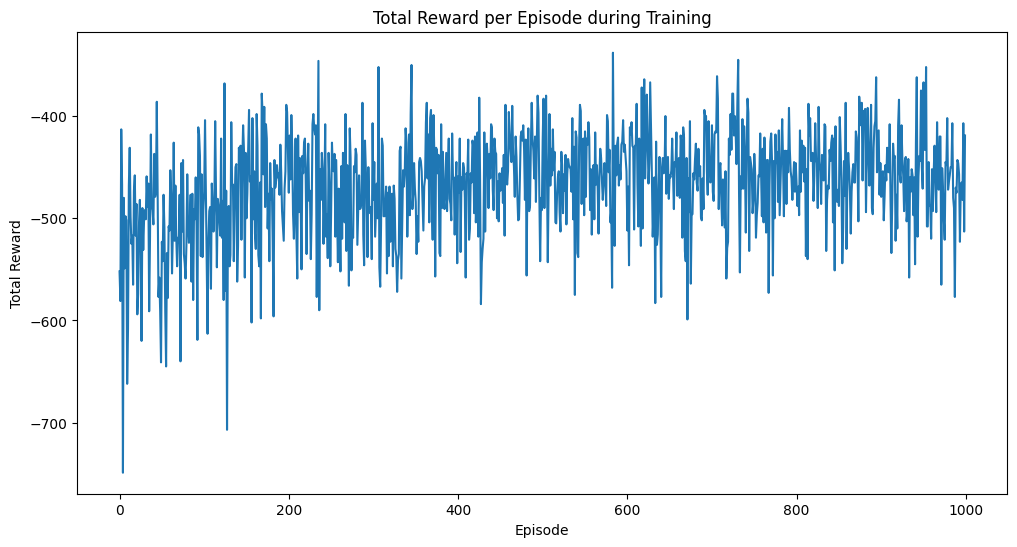

In [9]:
# Plot the total reward over episodes
plt.figure(figsize=(12, 6))
plt.plot(ql.rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode during Training')
plt.show()

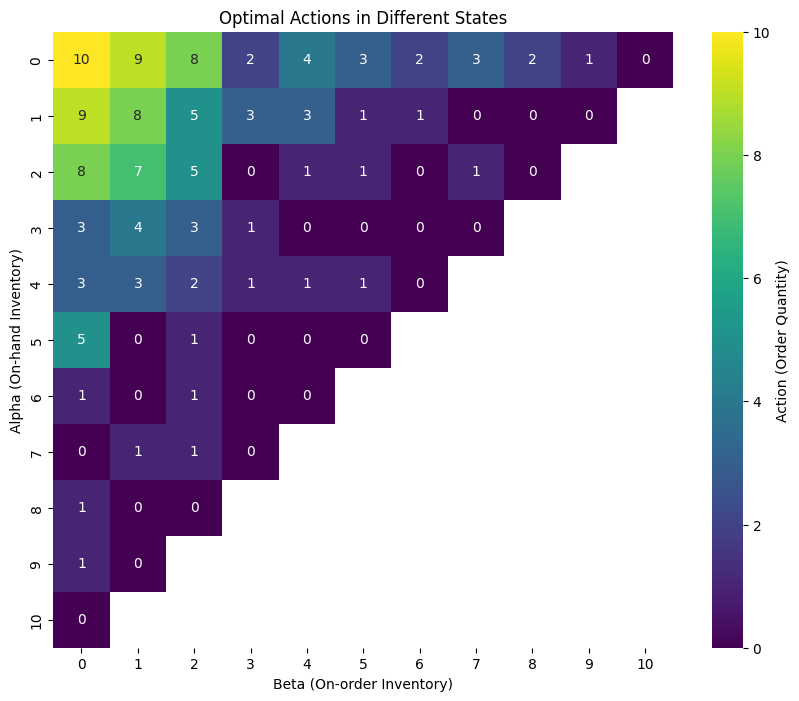

In [12]:
# Prepare data for heatmap
# Initialize a matrix to hold the action values
policy_matrix = np.full((user_capacity + 1, user_capacity + 1), np.nan)

# Loop over all possible values of alpha and beta
for alpha in range(user_capacity + 1):
    for beta in range(user_capacity + 1):
        # Only consider valid states where total inventory does not exceed capacity
        if alpha + beta <= user_capacity:
            state = (alpha, beta)
            action = optimal_policy.get(state, 0)
            policy_matrix[alpha, beta] = action  # Store the action in the matrix

# Convert the matrix to a DataFrame for better labeling in the heatmap
policy_df = pd.DataFrame(policy_matrix)
policy_df.index.name = 'Alpha (On-hand Inventory)'
policy_df.columns.name = 'Beta (On-order Inventory)'

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(policy_df, annot=True, fmt=".0f", cmap='viridis',
            cbar_kws={'label': 'Action (Order Quantity)'})
plt.title('Optimal Actions in Different States')
plt.show()